# Datathon FME 2022 : The Accenture Challenge

___ 

The code presented in this notebook is the result of the work of the @Shambala team composed of : 

- Walid Ider
- Marie Mayol
- Yannig Delorme 

During the 2nd Edition of the FME Datathon that took place in the UPC School of Mathematics and Statistics

This Datathon was also a part of the seminars of the SIRI-MIRI course of the Barcelona School of Informatics

___

### Subject and context : 

- Understanding main root-cause affecting supply chain deliveries and predicting product delays based on historical inbound/outbound orders of the company.
- Providing visibility of supply chain resiliency to maximize customer service levels.

##### What is it expected from the technical challenge?

- Provide data insights based on descriptive analytics of historical data.
- Predictive model to predict likelihood of order delay. The metric to evaluate models will be AUC (ROC), you must submit a predicted likelihood between 0 and 1 for the True class.

The data available will be four .csv files, containing various informations about the orders, products, and cities of shipment, as well as a testing file.

The submission will be then, done on Kaggle.

The results of this work were presented in front of a jury on the 13th November 2022.

___

### Importing Libraries

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from math import *
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import sklearn as sk
import itertools as it
import time

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier

import typing
from typing import Optional, Union, Tuple
import logging
import tqdm

from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.metrics import  mean_absolute_error, mean_squared_error
from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier

___
### Data Preprocessing and Visualisation

In [3]:
#importing the data : 

#path = "datathonfme2022-main/accenture_challenge/datathon_SC_ACN_22/"
path=""

for x in ["cities_data","orders","test"] : 
    locals()[x] = pd.read_csv(path + x + ".csv",sep=";")
product_attributes = pd.read_csv(path + "product_attributes.csv")

In [4]:
orders

,order_id,origin_port,3pl,customs_procedures,logistic_hub,customer,product_id,units,late_order
0,366c7a3d298f,Rotterdam,v_002,DTP,Venlo,Marseille,1692723,583,True
1,45f906331e10,Rotterdam,v_004,CRF,Rome,Marseille,1644308,459,False
2,ac84a6e4af0f,Athens,v_002,CRF,Venlo,Paris,1684170,464,True
3,f5e98cb29790,Rotterdam,v_004,CRF,Lille,Milan,1620510,678,False
4,a9e7c9bee35b,Barcelona,v_002,CRF,Venlo,Berlin,1699372,353,False
...,...,...,...,...,...,...,...,...,...
114271,3f4b15fb770e,Rotterdam,v_002,CRF,Dusseldorf,Bordeaux,1681376,645,False
114272,d2e6978a38fd,Barcelona,v_004,DTD,Dusseldorf,Berlin,1676942,502,False
114273,b88babd5c7bd,Rotterdam,v_002,DTP,Dusseldorf,Rome,1692737,464,False
114274,b0b5c761613f,Barcelona,v_003,DTD,Dusseldorf,Munich,1699974,388,False


In [5]:
product_attributes.describe()

,product_id,weight,material_handling
count,7.720000e+02,772.000000,772.000000
mean,1.682036e+06,1303.297927,3.164508
std,1.723441e+04,526.166950,1.707581
min,1.613321e+06,136.000000,0.000000
25%,1.671913e+06,937.500000,2.000000
50%,1.685214e+06,1292.500000,3.000000
75%,1.696982e+06,1659.500000,5.000000
max,1.702654e+06,2876.000000,5.000000


- A good idea to check the statistical distribution of a variable is to verify a boxplot

<AxesSubplot:>

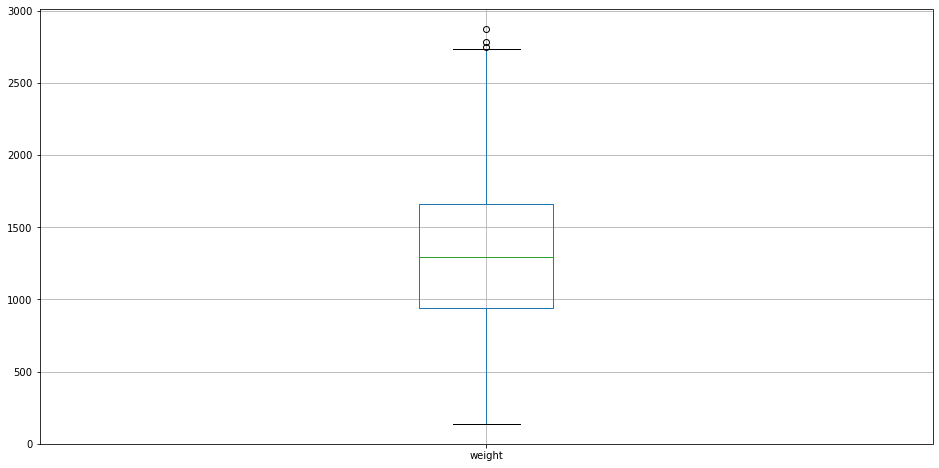

In [6]:
product_attributes.drop(columns=["product_id","material_handling"]).boxplot(figsize=(16,8))

We can also take a look at a histogram for our data:

array([[<AxesSubplot:title={'center':'False vs True'}>]], dtype=object)

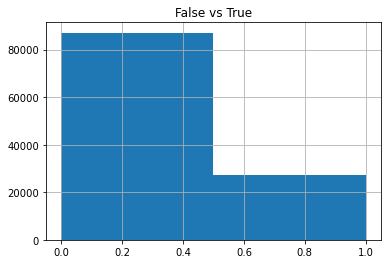

In [7]:
df_tmp=pd.DataFrame([1 if x==True else 0 for x in orders["late_order"]])
df_tmp.rename(columns={0 : "False vs True"},inplace=True)
df_tmp.hist(bins=2)

**Our strategy will be to unify our three datasets in an intuitive way. We believe that whether an order is late or not depends principally, regarding the two datasets other than "orders.csv", on the distance between the shipment base and the destination, as well as the weight and fragility of the materials.**

In [8]:
# Adding distances 
data = orders.copy()

distance_origin_hub= []
distance_hub_customer = []

for i in range(len(data)): 
    try : 
        distance_origin_hub.append(float(cities_data[(cities_data["city_from_name"] == data["origin_port"][i])& (cities_data["city_to_name"] == data["logistic_hub"][i])]["distance"]))
    except:
        distance_origin_hub.append(np.nan)
    try : 
        distance_hub_customer.append(float(cities_data[(cities_data["city_from_name"] == data["logistic_hub"][i] )& (cities_data["city_to_name"] == data["customer"][i])]["distance"]))
    except:
        distance_hub_customer.append(np.nan)
        
data["distance_origin_hub"]=distance_origin_hub
data["distance_hub_customer"] = distance_hub_customer       

In [9]:
data=data.join(product_attributes.set_index("product_id"), on = "product_id")

**We can also try to check the percentage of late orders beforehand**

In [10]:
print("Percentage of late orders : " + str(round((len(orders[orders["late_order"]==True])/len(orders))*100,2)) + " %")

Percentage of late orders : 23.76 %


**We have a lot of string values in our dataset, which is not friendly to some classification algorithms we are going to be using. Therefore, we are going to use a label encoder.**

In [11]:
def MassLabelEncoding(df) : 
    """
    Label Encoding on all string columns 
    of a non-empty DataFrame
    """
    le=LabelEncoder()
    firstRow = list(df.iloc[0])
    for i in range(len(firstRow)) : 
        if type(firstRow[i]) == str : 
            currentColumn = list(df.columns)[i]
            df[currentColumn] = le.fit_transform(df[currentColumn])
    return df

**In addition to that, many cities are represented twice, in another form, such as : "BCN" for "Barcelona" est...**

In [12]:
data.replace(["BCN","ATHENAS"],["Barcelona", "Athens"],inplace=True) #Replacing double values

**Given the fact that we are dealing with real values such as distances between cities, imputing a value in whatever strategy (mean, median, most_frequent...) would be irrelevant. Thus, we are going to drop for now the empty values from our dataset**

In [13]:
data.dropna(inplace=True) # removing all values, imputing values here would be irrelevant

**One quick look to a correlation clustermap before moving to the next part**

In [14]:
clustermap=0 # put =1 to visualise clustermap
if clustermap==1:
    sns.cluster(np.array(data.drop(columns=["origin_port" , "order_id" , "logistic_hub" , "customer", "late_order", "3pl", "customs_procedures"])))

In [15]:
data.drop(columns=["origin_port" , "order_id" , "logistic_hub" , "customer", "late_order", "3pl", "customs_procedures"]) # Data represented in the clustermap

,product_id,units,distance_origin_hub,distance_hub_customer,weight,material_handling
0,1692723,583,130.0459,902.0420,1778.0,5.0
1,1644308,459,1269.2365,604.0216,1088.0,3.0
3,1620510,678,173.9644,733.8784,1308.0,4.0
6,1699793,609,1269.2365,477.3222,2400.0,2.0
9,1699836,465,130.0459,1436.9241,445.0,3.0
...,...,...,...,...,...,...
114266,1674120,410,414.4489,901.2353,932.0,5.0
114270,1699689,695,1135.6449,816.0497,2369.0,0.0
114271,1681376,645,177.3075,896.2065,1896.0,3.0
114273,1692737,464,177.3075,1125.0290,572.0,5.0


- We define X and y :

In [16]:
X = data.drop(columns=["late_order","order_id","product_id"])
y = data["late_order"]

**We then proceed to scale X and encode the necessary values for both X and y. For example, True and False and y become 1 and 0**

In [17]:
X=MassLabelEncoding(X)

le=LabelEncoder()

y = le.fit_transform(y)

sc = StandardScaler()

X=sc.fit_transform(X)

**Now that our preprocessing is done, we can proceed with the train_test_split function and begin our model training**

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**We are going to choose a random forest classifier**

In [19]:
clf=RandomForestClassifier()

- Our score is therefore:

In [20]:
print("Score of the classification : " + str( round(clf.fit(X_train,y_train).score(X_test,y_test)*100,2)) + " %")

Score of the classification : 85.96 %


**We can analyze the importance of each of our features by looking at the following graph** 

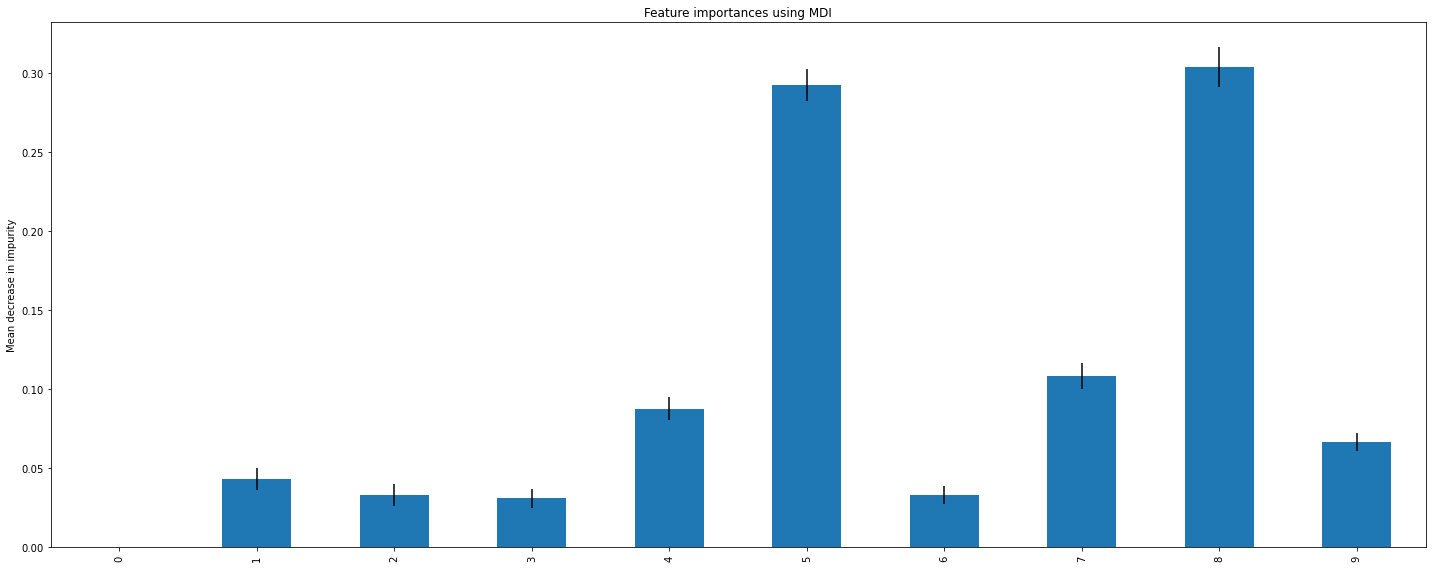

In [21]:
X=pd.DataFrame(X)

features= list(X.columns)
start_time = time.time()
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
elapsed_time = time.time() - start_time

forest_importances = pd.Series(importances, index=features)

fig, ax = plt.subplots(figsize=(20,8))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

**We can make the deduction that we can reduce our dataset by removing some features that are unnecessary, keeping therefore most of the information and improving the efficiency of our algorithm**

___
### Comparing with another model

We can also challenge our previous model by using an XGBoost Classifier, and see what output we can get out of it.

In [22]:
xgb=XGBClassifier()
print("Score of the classification : " + str( round(xgb.fit(X_train,y_train).score(X_test,y_test)*100,2)) + " %")

Score of the classification : 86.74 %


___
### Improving our model

**We are going to use a custom version of GridSearch in order to look for the best parameters for our classifier**

In [23]:
def check_early_stopping(
    scores: Union[list, np.ndarray],
    metric: str,
    stopping_rounds: int=4,
    stopping_tolerance: float=0.01,
    max_runtime_sec: int=None,
    start_time: pd.Timestamp=None) -> bool:
    
    """
    Check if early stopping condition is met.
    
    Parameters
    ----------
    
    scores: list, np.ndarray
        Scores used to evaluate early stopping conditions.
        
    metric: str
        Metric which scores referes to. Used to determine if higher score
        means a better model or the opposite.
        
    stopping_rounds: int, default 4
        Number of consecutive rounds without improvement needed to stop
        the training.
    
    stopping_tolerance: float, default 0.01
        Minimum percentage of positive change between two consecutive rounds
        needed to consider it as an improvement.
    
    max_runtime_sec: int, default `None`
        Maximum allowed runtime in seconds for model training. `None` means unlimited.
    
    start_time: pd.Timestamp, default `None`
        Time when training started. Used to determine if `max_runtime_sec` has been
        reached.
        
        
    Returns
    ------
    bool:
        `True` if any condition needed for early stopping is met. `False` otherwise.
        
    Notes
    -----
    
    Example of early stopping:
        
    Stop after 4 rounds without an improvement of 1% or higher: `stopping_rounds` = 4,
    `stopping_tolerance` = 0.01, `max_runtime_sec` = None.
    
    """
    
    allowed_metrics = ['accuracy', 'auc', 'f1', 'mse', 'mae', 'squared_error',
                       'absolute_error']
    
    if metric not in allowed_metrics:
        raise Exception(
                f"`metric` argument must be one of: {allowed_metrics}. "
                f"Got {metric}"
        )
    
    if isinstance(scores, list):
        scores = np.array(scores)
        
    if max_runtime_sec is not None:
        
        if start_time is None:
            start_time = pd.Timestamp.now()
            
        runing_time = (pd.Timestamp.now() - start_time).total_seconds()
        
        if runing_time > max_runtime_sec:
            logging.debug(
                f"Reached maximum time for training ({max_runtime_sec} seconds). "
                f"Early stopping activated."
            )
            return True
        
    if len(scores) < stopping_rounds:
        return False
    
    if metric in ['accuracy', 'auc', 'f1']:
        # The higher the metric, the better
        diff_scores = scores[1:] - scores[:-1]
        improvement = diff_scores / scores[:-1]
        
    if metric in ['mse', 'mae', 'squared_error', 'absolute_error']:
        # The lower the metric, the better
        
        # scores = -1 * scores 
        # diff_scores = scores[:-1] - scores[1:]
        # improvement = diff_scores / scores[1:]
        diff_scores = scores[1:] - scores[:-1]
        improvement = diff_scores / scores[:-1]
        improvement = -1 * improvement
        
    improvement = np.hstack((np.nan, improvement))
    logging.debug(f"Improvement: {improvement}")
    
    if (improvement[-stopping_rounds:] < stopping_tolerance).all():
        return True
    else:
        return False


    
def fit_RandomForest_early_stopping(
    model: Union[RandomForestClassifier, RandomForestRegressor],
    X: Union[np.ndarray, pd.core.frame.DataFrame],
    y: np.ndarray,
    metric: str,
    positive_class: int=1,
    score_tree_interval: int=None,
    stopping_rounds: int=4,
    stopping_tolerance: float=0.01,
    max_runtime_sec: int=None) -> np.ndarray:
    
    """
    Fit a RandomForest model until an early stopping condition is met or
    `n_estimatos` is reached.
    
    Parameters
    ----------
    
    model: RandomForestClassifier, RandomForestRegressor
        Model to be fitted.
        
    X: np.ndarray, pd.core.frame.DataFrame
        Training input samples. 
    
    y: np.ndarray, pd.core.frame.DataFrame
        Target value of the input samples. 
    
    scores: list, np.ndarray
        Scores used to evaluate early stopping conditions.
        
    metric: str
        Metric used to generate the score. Used to determine if higher score
        means a better model or the opposite.
        
    score_tree_interval: int, default `None`
        Score the model after this many trees. If `None`, the model is scored after
        `n_estimators` / 10.
        
    stopping_rounds: int
        Number of consecutive rounds without improvement needed to stop the training.
    
    stopping_tolerance: float, default 0.01
        Minimum percentage of positive change between two consecutive rounds
        needed to consider it as an improvement. 
    
    max_runtime_sec: int, default `None`
        Maximum allowed runtime in seconds for model training. `None` means unlimited.
        
        
    Returns
    ------
    oob_scores: np.ndarray
        Out of bag score for each scoring point.
    
    """
    
    if score_tree_interval is None:
        score_tree_interval = int(model.n_estimators / 10)
        
    allowed_metrics = ['accuracy', 'auc', 'f1', 'mse', 'mae', 'squared_error',
                       'absolute_error']
    
    if metric not in allowed_metrics:
        raise Exception(
                f"`metric` argument must be one of: {allowed_metrics}. "
                f"Got {metric}"
        )
    
    if not model.oob_score:
        model.set_params(oob_score=True)
        
    start_time = pd.Timestamp.now()
    oob_scores = []
    scoring_points = np.arange(0, model.n_estimators + 1, score_tree_interval)[1:]
    scoring_points = np.hstack((1, scoring_points))
    
    metrics = {
        'auc' : roc_auc_score,
        'accuracy' : accuracy_score,
        'f1': f1_score,
        'mse': mean_squared_error,
        'squared_error': mean_squared_error,
        'mae': mean_absolute_error,
        'absolute_error': mean_absolute_error,        
    }
    
    for i, n_estimators in enumerate(scoring_points):
        
        logging.debug(f"Training with n_stimators: {n_estimators}")
        model.set_params(n_estimators=n_estimators)
        model.fit(X=X, y=y)
        
        if metric == 'auc':
            oob_predictions = model.oob_decision_function_[:, positive_class]
            # If n_estimators is small it might be possible that a data point
            # was never left out during the bootstrap. In this case,
            # oob_decision_function_ might contain NaN.
            oob_score = metrics[metric](
                            y_true=y[~np.isnan(oob_predictions)],
                            y_score=oob_predictions[~np.isnan(oob_predictions)]
                        )
        else:
            oob_predictions = model.oob_decision_function_
            oob_predictions = np.argmax(oob_predictions, axis=1)
            oob_score = metrics[metric](
                            y_true=y[~np.isnan(oob_predictions)],
                            y_score=oob_predictions[~np.isnan(oob_predictions)]
                        )
            
        oob_scores.append(oob_score)
        
        early_stopping = check_early_stopping(
                            scores             = oob_scores,
                            metric             = metric,
                            stopping_rounds    = stopping_rounds,
                            stopping_tolerance = stopping_tolerance,
                            max_runtime_sec    = max_runtime_sec,
                            start_time         = start_time
                         )    
        
        if early_stopping:
            logging.debug(
                f"Early stopping activated at round {i + 1}: n_estimators = {n_estimators}"
            )
            break
        
    logging.debug(f"Out of bag score = {oob_scores[-1]}")
    
    return np.array(oob_scores), scoring_points[:len(oob_scores)]

In [24]:
def custom_gridsearch_RandomForestClassifier(
    model: RandomForestClassifier,
    X: Union[np.ndarray, pd.core.frame.DataFrame],
    y: np.ndarray,
    metric: str,
    param_grid: dict,
    positive_class: int=1,
    score_tree_interval: int=None,
    stopping_rounds: int=5,
    stopping_tolerance: float=0.01,
    model_max_runtime_sec: int=None,
    max_models: int=None,
    max_runtime_sec: int=None,
    return_best: bool=True) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    '''
    Grid search for RandomForestClassifier model based on out-of-bag metric and 
    early stopping for each model fit.
    
    Parameters
    ----------
    
    model: RandomForestClassifier
        Model to search over.
           
    X: np.ndarray, pd.core.frame.DataFrame
        The training input samples. 
    
    y: np.ndarray, pd.core.frame.DataFrame
        The target of input samples. 
    
    scores: list, np.ndarray
        Scores used to evaluate early stopping conditions.
        
    metric: str
        Metric used to generate the score. I is used to determine if higher score
        means a better model or the opposite.
        
    score_tree_interval: int, default `None`
        Score the model after this many trees. If `None`, the model is scored after
        `n_estimators` / 10.
        
    stopping_rounds: int
        Number of consecutive rounds without improvement needed to stop the training.
    
    stopping_tolerance: float, default 0.01
        Minimum percentage of positive change between two consecutive rounds
        needed to consider it as an improvement. 
    
    model_max_runtime_sec: int, default `None`
        Maximum allowed runtime in seconds for model training. `None` means unlimited.
        
    max_models: int, default `None`
        Maximum number of models trained during the search.
    
    max_runtime_sec: int, default `None`
        Maximum number of seconds for the search.
        
    return_best : bool
        Refit model using the best found parameters on the whole data.
        
        
    Returns
    ------
    
    results: pd.DataFrame
    
    '''
    
    results = {'params': [], 'oob_metric': []}
    start_time = pd.Timestamp.now()
    history_scores = {}
    history_scoring_points = np.array([], dtype = int)
    param_grid = list(ParameterGrid(param_grid))
    
    if not model.oob_score:
        model.set_params(oob_score=True)
    
    if max_models is not None and max_models < len(param_grid):
        param_grid = np.random.choice(param_grid, max_models)

    for params in tqdm.tqdm(param_grid):
        
        if max_runtime_sec is not None:
            runing_time = (pd.Timestamp.now() - start_time).total_seconds()
            if runing_time > max_runtime_sec:
                logging.info(
                    f"Reached maximum time for GridSearch ({max_runtime_sec} seconds). "
                    f"Search stopped."
                )
                break   
        
        model.set_params(**params)

        oob_scores, scoring_points = fit_RandomForest_early_stopping(
                                        model = clone(model), # Clone to avoid modification of n_estimators
                                        X = X,
                                        y = y,
                                        metric = metric,
                                        positive_class      = positive_class,
                                        score_tree_interval = score_tree_interval,
                                        stopping_rounds     = stopping_rounds,
                                        stopping_tolerance  = stopping_tolerance,
                                        max_runtime_sec     = model_max_runtime_sec
                                     )
      
        history_scoring_points = np.union1d(history_scoring_points,  scoring_points)        
        history_scores[str(params)] = oob_scores
        params['n_estimators'] = scoring_points[-1]
        results['params'].append(params)
        results['oob_metric'].append(oob_scores[-1])
        logging.debug(f"Modelo: {params} \u2713")

    results = pd.DataFrame(results)
    history_scores = pd.DataFrame(
                            dict([(k, pd.Series(v)) for k,v in history_scores.items()])
                         )
    history_scores['n_estimators'] = history_scoring_points
    
    if metric in ['accuracy', 'auc', 'f1']:
        results = results.sort_values('oob_metric', ascending=False)
    else:
        results = results.sort_values('oob_metric', ascending=True)
        
    results = results.rename(columns = {'oob_metric': f'oob_{metric}'})
    
    if return_best:
        best_params = results['params'].iloc[0]
        print(
            f"Refitting mode using the best found parameters and the whole data set: \n {best_params}"
        )
        
        model.set_params(**best_params)
        model.fit(X=X, y=y)
        
    results = pd.concat([results, results['params'].apply(pd.Series)], axis=1)
    results = results.drop(columns = 'params')
    
    return results, history_scores

In [25]:
param_grid = {
             'max_depth'   : [3, 10, 15, 20, 35 , 50],
             'max_features': ['sqrt', 'log2'],
             'ccp_alpha': [0, 0.01]
            }
clf= RandomForestClassifier(
            n_estimators = 100,
            oob_score    = True,
            n_jobs       = -1,
            random_state = 0
        )

gridsearch =0 # =1 if we want to do the gridsearch (requires 1 or 2 minutes for execution)

if gridsearch ==1: 

    start = pd.Timestamp.now()

    results, history = custom_gridsearch_RandomForestClassifier(
                            model                 = clf,
                            X                     = X,
                            y                     = y,
                            metric                = 'auc',
                            param_grid            = param_grid,
                            positive_class        = 1,
                            score_tree_interval   = 50,
                            stopping_rounds       = 4,
                            stopping_tolerance    = 0.01,
                            model_max_runtime_sec = None,
                            max_models            = None,
                            max_runtime_sec       = None,
                            return_best           = True
                          )

    end = pd.Timestamp.now()

    print("Duration : ", end - start)

#Returned value : {'ccp_alpha': 0, 'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 100}

**We are now going to use the output of this gridsearch as a parameter for our classifier**

In [26]:
clf = RandomForestClassifier(**{'criterion' : 'entropy' , 'ccp_alpha': 0, 'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 100})

In [27]:
data.drop(columns=["origin_port", "3pl", "customs_procedures", "logistic_hub", "distance_origin_hub","product_id"],inplace=True)

data.dropna(inplace=True)
X = data.drop(columns=["late_order","order_id"])
y = data["late_order"]

X=MassLabelEncoding(X)

le=LabelEncoder()

y = le.fit_transform(y)

sc = StandardScaler()

sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
print("Score of the classification : " + str( round(clf.fit(X_train,y_train).score(X_test,y_test)*100,2)) + " %")

Score of the classification : 86.01 %


**We therefore notice a slight improvement of our model**

### Final results

**Our model only makes sense if we apply it on the same "type" of data, we therefore need to make the same modifications to the test.csv dataset**

In [29]:
data = test.copy()

distance_origin_hub= []
distance_hub_customer = []

for i in range(len(data)): 
    try : 
        distance_origin_hub.append(float(cities_data[(cities_data["city_from_name"] == data["origin_port"][i])& (cities_data["city_to_name"] == data["logistic_hub"][i])]["distance"]))
    except:
        distance_origin_hub.append(np.nan)
    try : 
        distance_hub_customer.append(float(cities_data[(cities_data["city_from_name"] == data["logistic_hub"][i] )& (cities_data["city_to_name"] == data["customer"][i])]["distance"]))
    except:
        distance_hub_customer.append(np.nan)
        
data["distance_origin_hub"]=distance_origin_hub
data["distance_hub_customer"] = distance_hub_customer           

data=data.join(product_attributes.set_index("product_id"), on = "product_id")

data.replace(["BCN","ATHENAS"],["Barcelona", "Athens"],inplace=True) #Replacing double values

#data.dropna(inplace=True) # removing all values, imputing values here would be irrelevant

data.drop(columns=["origin_port", "3pl", "customs_procedures", "logistic_hub", "distance_origin_hub","product_id"],inplace=True)

X = data.drop(columns=["order_id"])

X=MassLabelEncoding(X)

sc = StandardScaler()

sc.fit_transform(X)

array([[ 0.55801758, -0.10701816, -0.30119298,  1.38288656,  1.09383396],
       [-1.28576687, -3.58577962, -0.86966926,  2.15166353, -1.8726682 ],
       [ 0.80385551,  0.31865307,  0.21974687, -0.80472183,  1.09383396],
       ...,
       [ 0.43509862, -0.01894825, -0.5256005 , -0.89425029,  1.09383396],
       [ 0.43509862,  1.16999554, -0.45524204, -0.34734819, -0.09276691],
       [-0.79409102, -0.32719294, -0.31141627, -1.73503928,  0.50053352]])

**We also need, in this case, to impute values**

In [30]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

X=imp.fit_transform(X)
pd.DataFrame(X).describe()

,0,1,2,3,4
count,28563.000000,28563.000000,28563.000000,28563.000000,28563.000000
mean,13.460281,484.290901,966.217380,1263.192137,3.159262
std,8.135584,68.128888,531.843906,513.454367,1.685775
min,0.000000,108.000000,34.429100,136.000000,0.000000
25%,6.000000,447.000000,558.146400,900.000000,2.000000
50%,14.000000,485.000000,847.308200,1230.000000,3.000000
75%,20.000000,522.000000,1309.179000,1627.000000,5.000000
max,27.000000,983.000000,2768.966300,2876.000000,5.000000


In [31]:
y=clf.predict_proba(X)
y_final=[x[1] for x in y]
test["late_order"]=y_final
df_final=test.drop(columns =[ "origin_port" , "3pl", "customs_procedures" , "logistic_hub" , "customer", "product_id","units"])
df_final

,order_id,late_order
0,0e364fa5c795,0.141132
1,3ef49bd5a55b,0.042655
2,9ab5b9685bd5,0.177090
3,bfce5b4fc4fa,0.542308
4,d94453ec8ec5,0.389478
...,...,...
28558,d268acf6459e,0.150236
28559,1aefc30b0eb3,0.157927
28560,646a2e50e170,0.094922
28561,bf5177549be9,0.089954


- Exporting to csv...

In [32]:
Export=0
if Export==1 :
    df_final.to_csv("submission_kaggle.csv", index=False)